In [ ]:
import numpy as np
import specsuite as ss

## 📁 __Loading FITS Data__
Our example data is separated into two separate directories. Calibration exposures (e.g., filenames with "argon," "bias," and "flat") are combined into a single median exposure, and each science exposure (e.g., filenames with "toi3884") loaded as a ```numpy.ndarray```.

In [56]:
TRACE_REGION = [650, 850]

### Defines the directories to all data files
CAL_PATH = "../data/KOSMOS/calibrations"
DATA_PATH = "../data/KOSMOS/target"

### Loads median calibration exposures
bias = ss.average_matching_files(CAL_PATH, "bias", crop_bds=TRACE_REGION, debug=True)
arc = ss.average_matching_files(CAL_PATH, "neon", crop_bds=TRACE_REGION, debug=True) - bias
flat = ss.average_matching_files(CAL_PATH, "flat", crop_bds=TRACE_REGION, debug=True) - bias

### Loads all individual science exposures
science = ss.collect_images_array(DATA_PATH, "toi3884", crop_bds=TRACE_REGION) - bias


Searching for files with 'bias' tag...
------------------------------------------
bias.0001.fits
bias.0002.fits
bias.0003.fits
bias.0004.fits
bias.0005.fits

Image statistics for average 'bias' image...
      Min: 2994.0
      Max: 8652.0
     Mean: 3350.255
      STD: 16.788

Searching for files with 'neon' tag...
------------------------------------------
neon.0014.fits
neon.0015.fits
neon.0016.fits

Image statistics for average 'neon' image...
      Min: 2994.0
      Max: 262143.0
     Mean: 5496.749
      STD: 15967.069

Searching for files with 'flat' tag...
------------------------------------------
flat.0029.fits
flat.0030.fits
flat.0031.fits
flat.0032.fits
flat.0033.fits

Image statistics for average 'flat' image...
      Min: 3334.0
      Max: 261334.0
     Mean: 109781.849
      STD: 94092.041


We can also quickly display these exposures using...

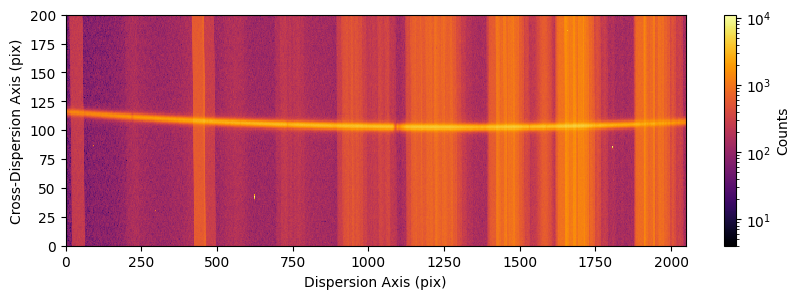

In [57]:
ss.plot_image(science[0], norm='log')

## 🔦 __Flatfield Normalization__
Performing a flatfield correction is as simple as running...

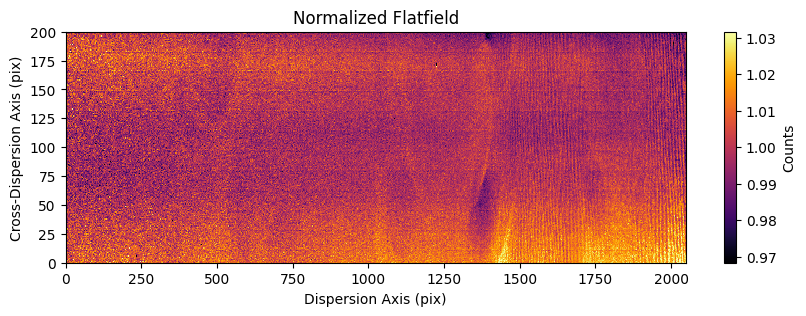

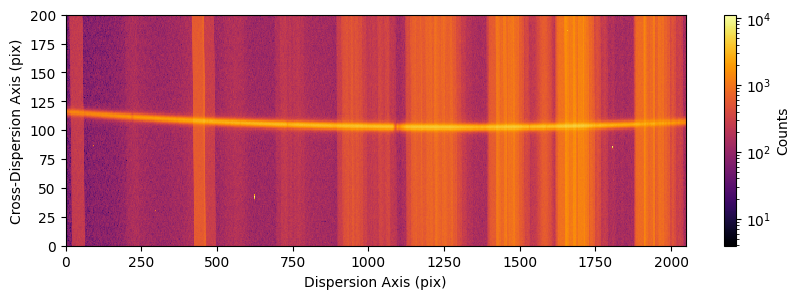

In [58]:
science_normed = ss.flatfield_correction(science, flat, debug=True)
ss.plot_image(science_normed[0], norm='log')

## ☁️ __Background Extraction__
```specsuite``` uses "warp models" to perform its background extraction. If you have an arclamp exposure, then the following functions should generate a decent first version...

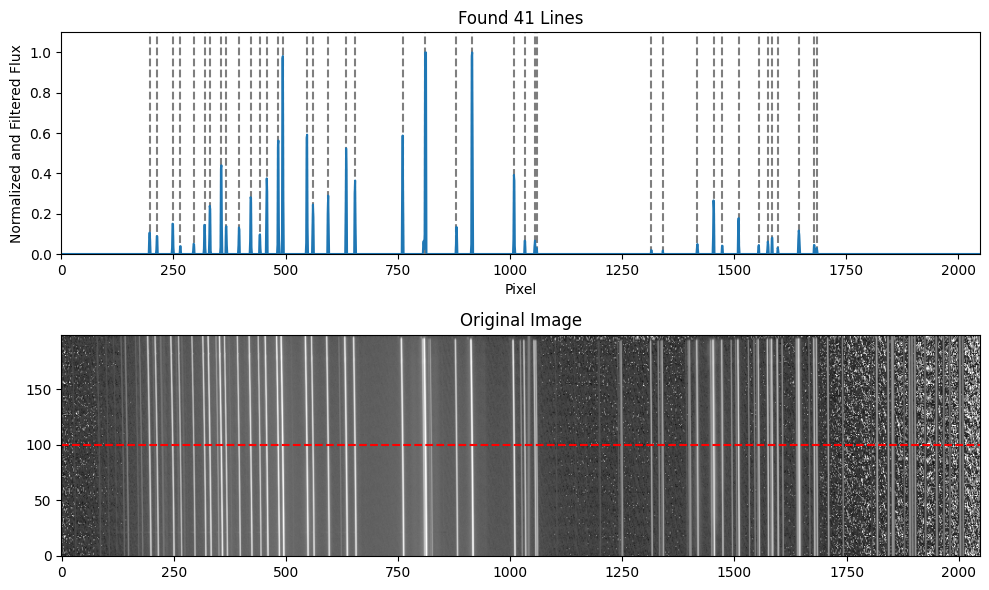

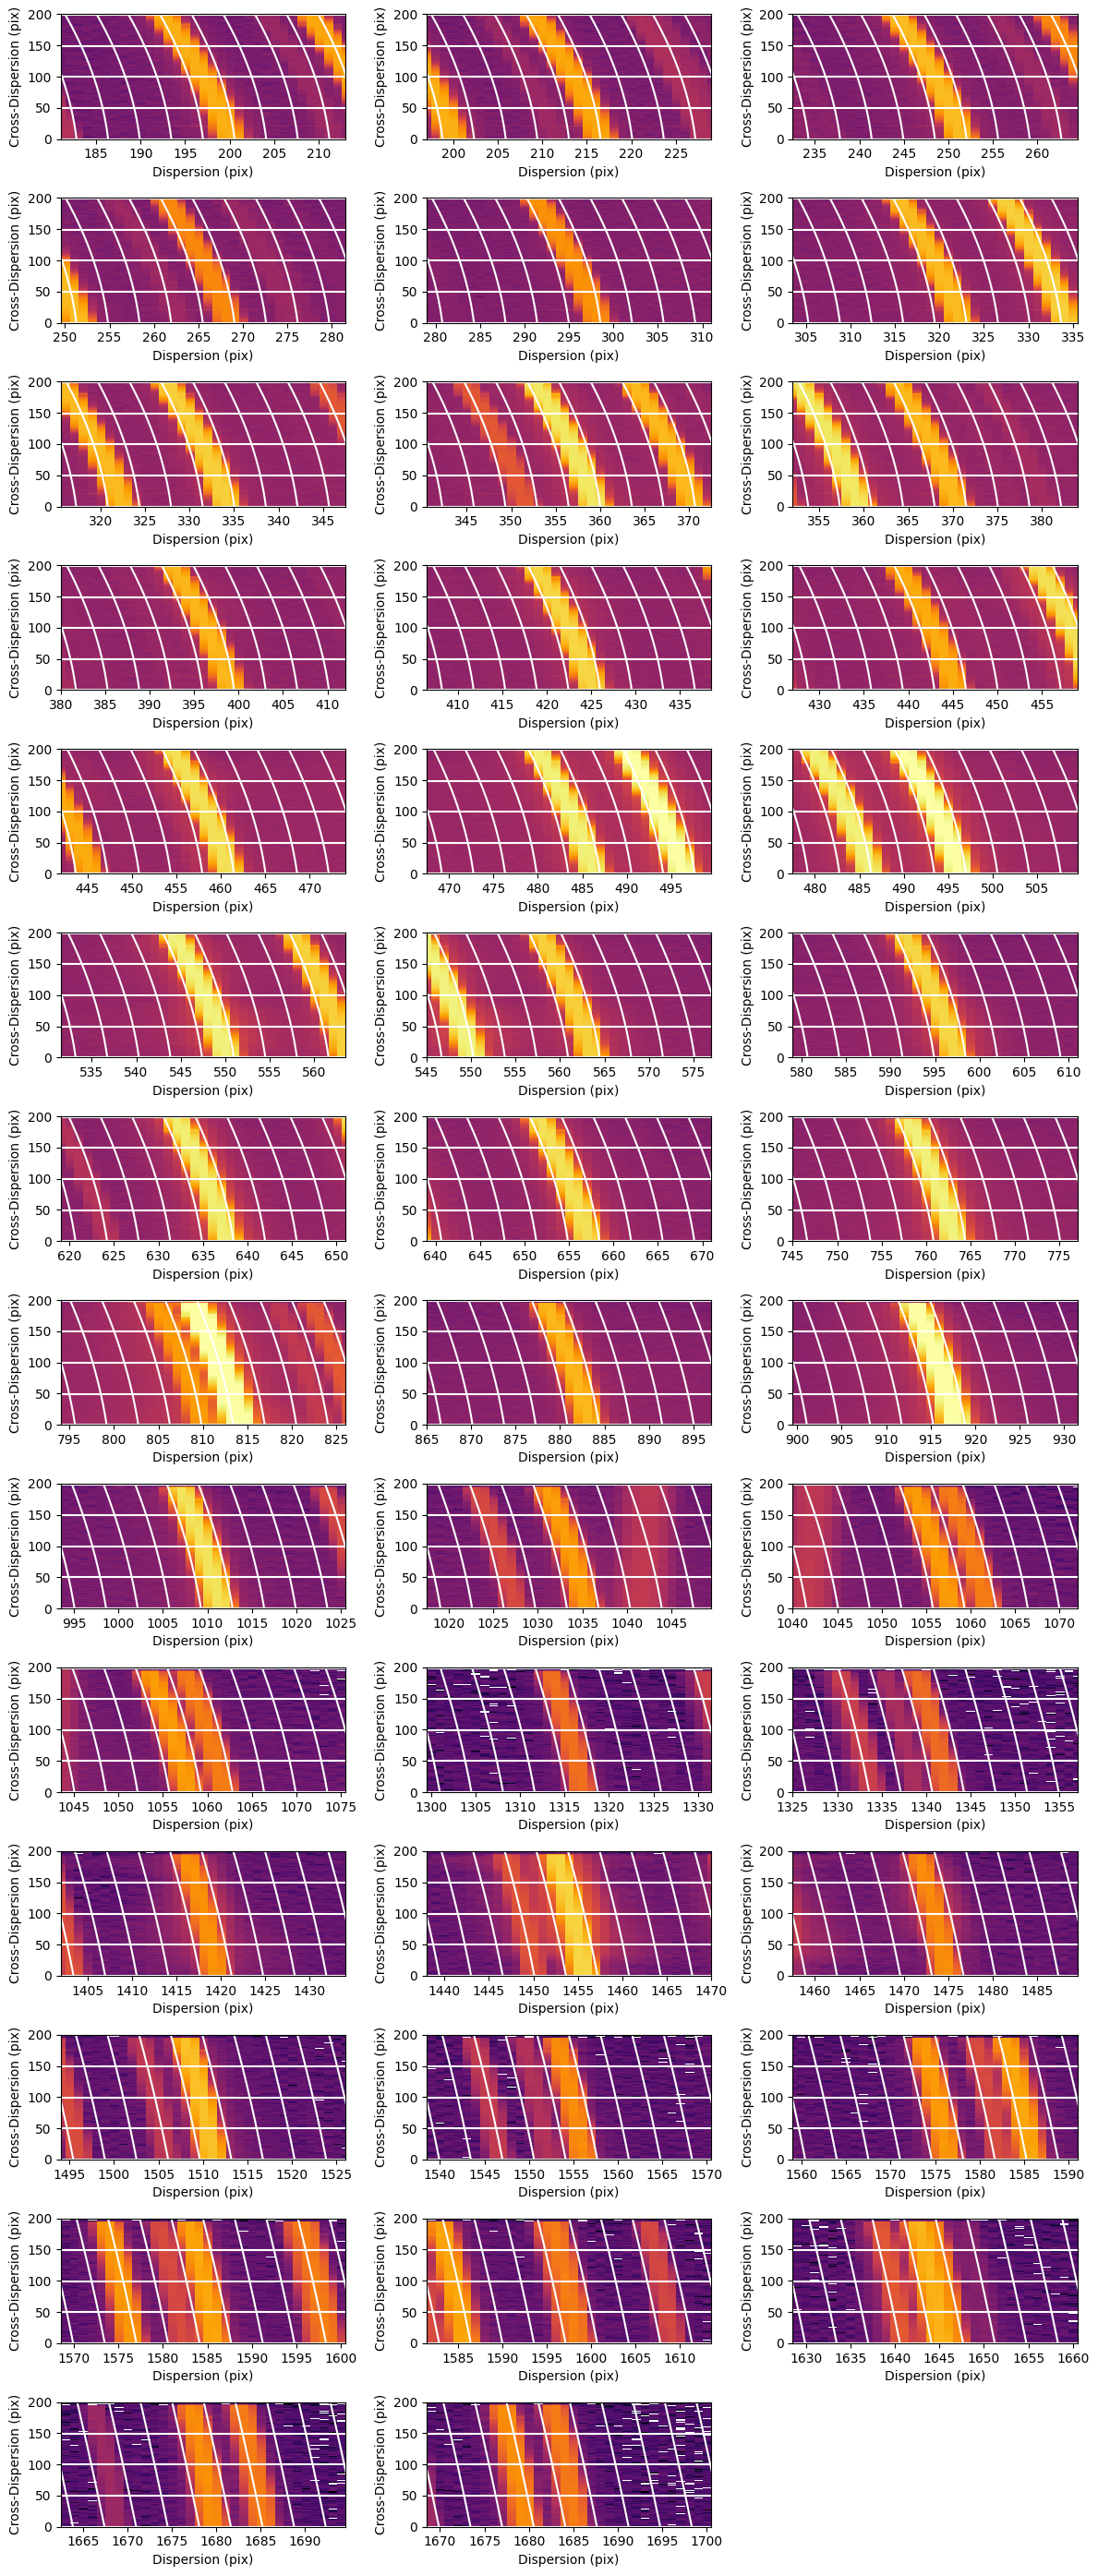

In [59]:
line_locs, line_amps = ss.find_cal_lines(arc, debug=True, std_variation=50)
warp_model = ss.generate_warp_model(arc, guess=line_locs, debug=True)

We can plug this ```warp_model``` into an extraction algorithm...

In [60]:
backgrounds = ss.extract_background(science_normed, warp_model, mask_region=(75, 150), debug=True)

ss.plot_image(backgrounds[0], norm='log')
ss.plot_image(np.abs((science-backgrounds)[0]), norm='log')

KeyboardInterrupt: 

## 🌟 __Flux Extraction__
One of ```specsuite```'s available flux extraction methods follows the "optimal extraction algorithm" outlined in __[Horne (1985)](https://articles.adsabs.harvard.edu/pdf/1986PASP...98..609H)__. Although you should customize several of its optional arguments for your telescope, it's simplest call is...

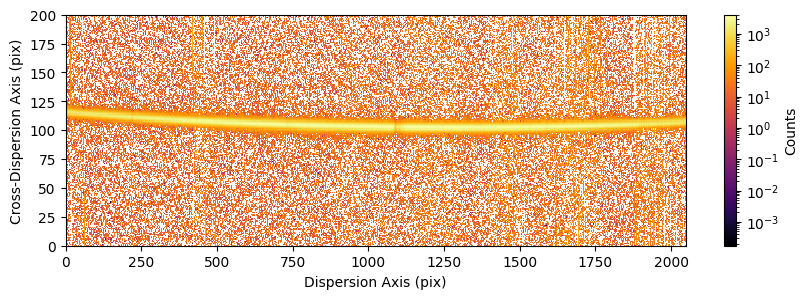

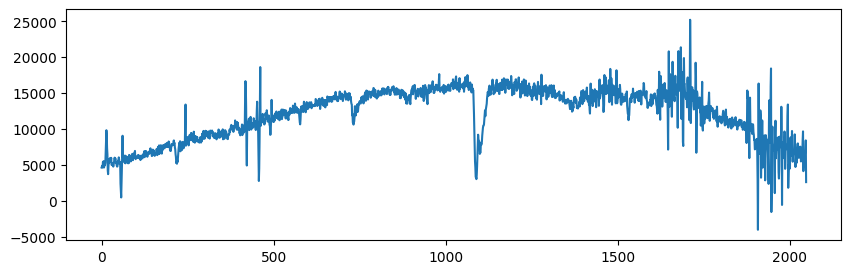

In [ ]:
# flux, err = ss.horne_extraction(
#     (science-backgrounds)[:1], backgrounds[:1],
#     update=True,
#     sigma_clip=100,
#     max_iter=1,
#     bin_size=32,
#     profile_order = 2,
#     repeat=False,
#     debug=True,
#     profile="moffat",
# )

# import matplotlib.pyplot as plt
# plt.plot(flux)

science_calibrated = science - backgrounds

ss.plot_image(science_calibrated[1], norm='log')

flux = np.sum(science_calibrated[1], axis=0)

import matplotlib.pyplot as plt
plt.plot(flux)

In [ ]:
# %matplotlib inline
# ss.plot_image(science[0][0:None], norm='log')